In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import pyro

from src.data.preprocessing import load_thickness_time_series
from src.models.paths import PROJECT_ROOT
from src.models.solid_earth_utils import compute_love_numbers, greens_function

print(PROJECT_ROOT)

/data/eigil/work/premis


In [10]:
from torch.distributions import constraints
from torch.distributions.transforms import AbsTransform

from pyro.distributions.torch import TransformedDistribution
from torch.distributions.transforms import Transform 

class IntervalTransform(Transform):
    r"""
    Transform via the mapping :math:`y = a <= x <= b`.
    """
    domain = constraints.real
    codomain = constraints.positive
    def __init__(self, a, b, event_dim=0, cache_size=0):
        self.a = a
        self.b = b
        self._event_dim = event_dim
        self._cache_size = cache_size
        
    def __eq__(self, other):
        return isinstance(other, IntervalTransform(self.a, self.b))

    def _call(self, x):
        x[self.a > x] = self.a
        x[self.b < x] = self.b
        return x

    def _inverse(self, y):
        return y

class IntervalFoldedDistribution(TransformedDistribution):
    """
    Equivalent to ``TransformedDistribution(base_dist, AbsTransform())``,
    but additionally supports :meth:`log_prob` .

    :param ~torch.distributions.Distribution base_dist: The distribution to
        reflect.
    """

    support = constraints.positive

    def __init__(self, base_dist, validate_args=None, lower=8e3, upper=1.4e4):
        if base_dist.event_shape:
            raise ValueError("Only univariate distributions can be folded.")
        super().__init__(base_dist, IntervalTransform(a=lower, b=upper), validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(type(self), _instance)
        return super().expand(batch_shape, _instance=new)


    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        dim = max(len(self.batch_shape), value.dim())
        plus_minus = value.new_tensor([1.0, -1.0]).reshape((2,) + (1,) * dim)
        return self.base_dist.log_prob(plus_minus * value).logsumexp(0)

In [11]:
from torch.distributions import constraints
from torch.distributions.transforms import AbsTransform

from pyro.distributions.torch import TransformedDistribution
from torch.distributions.transforms import Transform 

class IntervalTransform(Transform):
    r"""
    Transform via the mapping :math:`y = a <= x <= b`.
    """
    domain = constraints.real
    codomain = constraints.positive
    def __init__(self, a, b, event_dim=0, cache_size=0):
        self.a = a
        self.b = b
        self._event_dim = event_dim
        self._cache_size = cache_size
        
    def __eq__(self, other):
        return isinstance(other, IntervalTransform(self.a, self.b))

    def _call(self, x):
        x[self.a > x] = self.a
        x[self.b < x] = self.b
        return x

    def _inverse(self, y):
        return y

class IntervalFoldedDistribution(TransformedDistribution):
    """
    Equivalent to ``TransformedDistribution(base_dist, AbsTransform())``,
    but additionally supports :meth:`log_prob` .

    :param ~torch.distributions.Distribution base_dist: The distribution to
        reflect.
    """

    support = constraints.positive

    def __init__(self, base_dist, validate_args=None, lower=8e3, upper=1.4e4):
        if base_dist.event_shape:
            raise ValueError("Only univariate distributions can be folded.")
        super().__init__(base_dist, IntervalTransform(a=lower, b=upper), validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(type(self), _instance)
        return super().expand(batch_shape, _instance=new)


    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        dim = max(len(self.batch_shape), value.dim())
        plus_minus = value.new_tensor([1.0, -1.0]).reshape((2,) + (1,) * dim)
        return self.base_dist.log_prob(plus_minus * value).logsumexp(0)

In [3]:
Nr = np.arange(1, 6).tolist()
radius = [6371e3, 6301e3, 5951e3, 5701e3, 3480e3]
density = [3.037e3, 3.438e3, 3.871e3, 4.978e3, 10.750e3]
rigidity = [0.50605e11, 0.70363e11, 1.05490e11, 2.28340e11, 0.0000e11]
bulk = [5.7437e10, 9.9633e10, 1.5352e11, 3.2210e11, 1.1018e12]
viscosity = [1.0e55, 1.0e21, 1.0e21, 2.0e21, 0.0e21]

df_em = pd.DataFrame(
    np.array([Nr, radius, density, rigidity, bulk, viscosity]).T,
    columns=["Nr", "radius", "density", "rigidity", "bulk", "viscosity"],
)

lmax = 256
lmin = 0
lstep = 1
CONF = {
    "EARTH_FILE": "earth_M3L70V01c.txt",
    "COMPRESS": "1",
    "DEGREE_RANGE": f"{lmin} {lmax} {lstep}",
    "LABEL_OUTPUT": f"Bench_C_{lmax}_{lmin}_{lstep}",
}

df_kuaq = pd.read_csv(PROJECT_ROOT / "data" / "processed" / "KUAQ_filtered.csv")
df_kuaq.Time = pd.to_datetime(df_kuaq.Time)
# df_mass = pd.read_csv(PROJECT_ROOT / "data" / "processed" / "mass_time_series.csv")
df_height = load_thickness_time_series(
    PROJECT_ROOT / "data" / "processed" / "1900_2020_mean_thickness.mat"
)
df = pd.merge(df_height, df_kuaq, how="inner")

height = df.Thickness.values
uplift = df.Up.values

df_em

,Nr,radius,density,rigidity,bulk,viscosity
0,1.0,6371000.0,3037.0,5.060500e+10,5.743700e+10,1.000000e+55
1,2.0,6301000.0,3438.0,7.036300e+10,9.963300e+10,1.000000e+21
2,3.0,5951000.0,3871.0,1.054900e+11,1.535200e+11,1.000000e+21
3,4.0,5701000.0,4978.0,2.283400e+11,3.221000e+11,2.000000e+21
4,5.0,3480000.0,10750.0,0.000000e+00,1.101800e+12,0.000000e+00


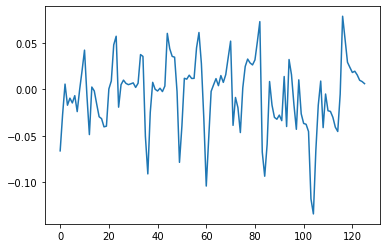

In [16]:
hlove, nlove = compute_love_numbers(df_em=df_em, CONF=None, verbose=0)
gf = greens_function(hlove, nlove, [68.704665, -33.214577], [68.58700000, -33.05270000], arsurf=30e3*30e3)

plt.plot(gf * height)

In [98]:
def model(height, obs=None, df_em=None):
    N = len(height)
    X = torch.arange(N)
    alpha = pyro.sample("alpha",dist.Normal(-100,10))
    beta = pyro.sample("beta", dist.Normal(1,1))
    sigma_w = 1 #pyro.sample("sigma", dist.HalfCauchy(0.1))
    
    # rigidity layer 1
    loc, scale = 2, 0.5
    rigidity_dist_1 = IntervalFoldedDistribution(dist.Normal(loc, scale), lower=loc * 1e-2, upper=loc * 1e2)
    rigidity_1 = 1e10 * pyro.sample("rigidity_1", rigidity_dist_1)
        
    # rigidity layer 2
    # rigidity_dist_2 = dist.Normal(1, 0.2)
    # rigidity_2 = 1e10 * pyro.sample("rigidity_2", rigidity_dist_2)    
    
    # dictionary = {"sample": sample1}
    df_em["rigidity"][0] = rigidity_1.item()

    # Draw Love Numbers
    hlove, nlove = compute_love_numbers(df_em=df_em, CONF=None, verbose=0)
    
    # Draw Greens Function
    gf = greens_function(hlove, nlove, [68.704665, -33.214577], [68.58700000, -33.05270000], arsurf=30e3*30e3)

    # Draw target
    w = pyro.sample("w", dist.Normal(alpha + X * beta + gf * height, sigma_w), obs=obs)
    
    return w

In [99]:
X_train = torch.tensor(height).float()
y_train = torch.tensor(uplift).float()

In [100]:
# Run inference in Pyro
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=150, warmup_steps=5, num_chains=1)
mcmc.run(X_train, y_train, df_em)

# Show summary of inference results
mcmc.summary()

Sample: 100%|██| 155/155 [28:17, 10.95s/it, step size=1.57e-03, acc. prob=0.880]


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       alpha    -20.45     15.32    -19.62    -39.90     -0.34      2.67      2.23
        beta      0.45      0.18      0.44      0.21      0.69      2.67      2.23
  rigidity_1      1.06      0.10      1.01      0.98      1.26      3.16      1.80

Number of divergences: 0


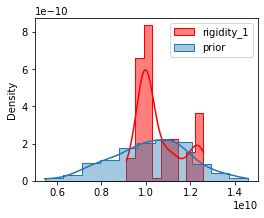

In [101]:
samples = {k: v for k, v in mcmc.get_samples().items()}
nodes = ["rigidity_1"]

rigidity_dist_prior = dist.Normal(torch.ones(150), 0.2)
rigidity_prior = 1e10 * pyro.sample("rigidity_prior", rigidity_dist_prior)

for node in nodes:
    plt.figure(figsize=(4,3))
    sns.histplot(samples[node]*1e10, label=node, kde=True, stat='density', element="step", color="red")
    sns.histplot(rigidity_prior, label="prior", kde=True, stat='density', element="step", alpha=0.4)
    plt.legend()
    plt.show()

In [127]:
df_em

,Nr,radius,density,rigidity,bulk,viscosity
0,1.0,6371000.0,3037.0,9.838532e+09,5.743700e+10,1.000000e+55
1,2.0,6301000.0,3438.0,7.036300e+10,9.963300e+10,1.000000e+21
2,3.0,5951000.0,3871.0,1.054900e+11,1.535200e+11,1.000000e+21
3,4.0,5701000.0,4978.0,2.283400e+11,3.221000e+11,2.000000e+21
4,5.0,3480000.0,10750.0,0.000000e+00,1.101800e+12,0.000000e+00


In [ ]:
N = len(height)
X = torch.arange(N)



In [120]:
posterior_samples = mcmc.get_samples()

alpha_hat = mcmc.get_samples(1)["alpha"]
beta_hat = mcmc.get_samples(1)["beta"]
rigidity_hat = mcmc.get_samples(1)["rigidity_1"]

rigidity_hat

,Nr,radius,density,rigidity,bulk,viscosity
0,1.0,6371000.0,3037.0,inf,5.743700e+10,1.000000e+55
1,2.0,6301000.0,3438.0,7.036300e+10,9.963300e+10,1.000000e+21
2,3.0,5951000.0,3871.0,1.054900e+11,1.535200e+11,1.000000e+21
3,4.0,5701000.0,4978.0,2.283400e+11,3.221000e+11,2.000000e+21
4,5.0,3480000.0,10750.0,0.000000e+00,1.101800e+12,0.000000e+00


In [121]:
df_em["rigidity"][0] = rigidity_hat.item() * 1e10
hlove, nlove = compute_love_numbers(df_em=df_em, CONF=None, verbose=0)
gf = greens_function(hlove, nlove, [68.704665, -33.214577], [68.58700000, -33.05270000])

In [130]:
alpha_hat

tensor([-0.6047])

In [132]:
y_hat = alpha_hat + X * beta_hat + gf * height

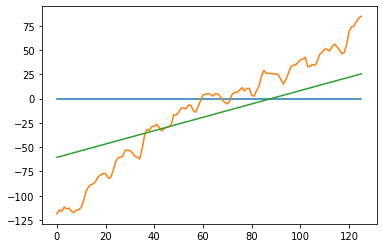

In [133]:
plt.plot(gf * height)
plt.plot(uplift)
plt.plot(y_hat)

## Different things from earlier work

In [ ]:
dont run the next cells

In [ ]:
class TruncatedNormal(dist.Rejector):
    def __init__(self, loc, scale_0, max_x0):
        propose = dist.Normal(loc, scale_0)

        def log_prob_accept(x):
            return (x[0] < max_x0).type_as(x).log()

        log_scale = torch.tensor(dist.LogNormal(loc, scale_0).cdf(max_x0)).log()
        super(TruncatedLogNormal, self).__init__(propose, log_prob_accept, log_scale)

In [ ]:
## TODO: For guide support, see: https://forum.pyro.ai/t/truncated-log-normal-distribution/2002
# from torch.distributions import constraints

# class TruncatedLogNormal(dist.Rejector):
#     ...
#     @constraints.dependent_property
#     def support(self):
#         return constraints.interval(0, self.max_x0)

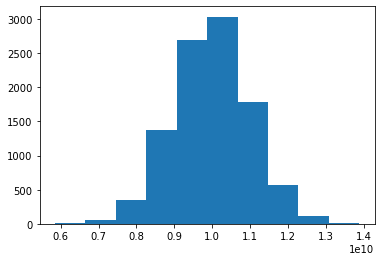

In [ ]:
diste = IntervalFoldedDistribution(dist.Normal(1e10*torch.ones(10000), 1e9), lower=1e8, upper=1e12)
plt.hist(np.array(pyro.sample("test", diste)));

tensor(0.)

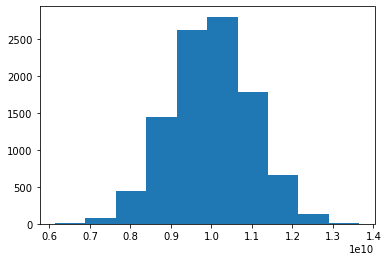

In [ ]:
samples = 1e10 * pyro.sample("test", dist.Normal(torch.ones(10000), 0.1))
plt.hist(np.array(samples));
samples[samples < 1e8].sum()

In [208]:
import numpyro
import numpyro.distributions as np_dist
from numpyro.infer import MCMC, NUTS

def model():

    # sample1 = numpyro.sample("rigidity1", bounded_rig1)
    rigidity_unscaled = numpyro.sample("rigidity_unscaled", np_dist.Normal(0, 1))
    
    rigidity_scaled = numpyro.deterministic("rigidity_scaled", 1e10 + 1e9 * rigidity_unscaled)
    # rigidity_scaled = numpyro.sample("rigidity_scaled", np_dist.Uniform(1e9, 1e11))

    
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model)
num_samples = 10000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)
mcmc.run(rng_key_)

print(mcmc.get_samples()["rigidity_scaled"].min() , mcmc.get_samples()["rigidity_scaled"].mean(), mcmc.get_samples()["rigidity_scaled"].max())

sample: 100%|██████████| 11000/11000 [00:14<00:00, 774.53it/s, 3 steps of size 1.26e+00. acc. prob=0.89]


-3806359800.0 -24906074.0 4083562800.0


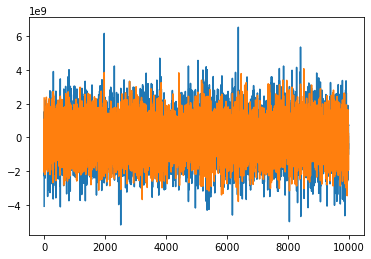

In [209]:
samples = mcmc.get_samples()["rigidity_scaled"].to_py()
plt.plot(np.diff(samples))
plt.plot(samples)

In [166]:
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

def model(height, obs=None, df_em=None):
    sample1 = pyro.sample("rigidity1", dist.Normal(1, 1e-1))

# Run inference in Pyro
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=1, num_chains=1)
mcmc.run(X_train, y_train, df_em)

print(mcmc.get_samples()["rigidity1"].min() , mcmc.get_samples()["rigidity1"].mean(), mcmc.get_samples()["rigidity1"].max())

Sample: 100%|██████████| 1001/1001 [12:24,  1.34it/s, step size=1.16e-10, acc. prob=1.000]

tensor(0.8238) tensor(0.9997) tensor(1.)
